In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 2

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 2s 25ms/step - loss: 0.5824 - accuracy: 0.7471 - val_loss: 0.5446 - val_accuracy: 0.7367
Epoch 2/200
97/99 [============================>.] - ETA: 0s - loss: 0.4616 - accuracy: 0.7671
Epoch 00002: val_loss improved from inf to 0.40538, saving model to best_model_3.h5
99/99 [==============================] - 2s 22ms/step - loss: 0.4618 - accuracy: 0.7671 - val_loss: 0.4054 - val_accuracy: 0.7738
Epoch 3/200
97/99 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.8080
Epoch 00003: val_loss improved from 0.40538 to 0.36419, saving model to best_model_3.h5
99/99 [==============================] - 2s 22ms/step - loss: 0.3781 - accuracy: 0.8080 - val_loss: 0.3642 - val_accuracy: 0.8146
Epoch 4/200
97/99 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.8225
Epoch 00004: val_loss improved from 0.36419 to 0.36143, saving model to best_model_3.h5
99/99 [==============================] - 2s 22ms/step

97/99 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9298
Epoch 00029: val_loss did not improve from 0.16769
99/99 [==============================] - 3s 29ms/step - loss: 0.1769 - accuracy: 0.9293 - val_loss: 0.1742 - val_accuracy: 0.9287
Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9252
Epoch 00030: val_loss did not improve from 0.16769
99/99 [==============================] - 3s 29ms/step - loss: 0.1831 - accuracy: 0.9252 - val_loss: 0.1734 - val_accuracy: 0.9278
Epoch 31/200
98/99 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9238
Epoch 00031: val_loss did not improve from 0.16769
99/99 [==============================] - 3s 31ms/step - loss: 0.1880 - accuracy: 0.9240 - val_loss: 0.2095 - val_accuracy: 0.9059
Epoch 32/200
99/99 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9312
Epoch 00032: val_loss improved from 0.16769 to 0.16614, saving model to best_model_3.h

Epoch 58/200
99/99 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9512
Epoch 00058: val_loss did not improve from 0.12780
99/99 [==============================] - 4s 40ms/step - loss: 0.1171 - accuracy: 0.9512 - val_loss: 0.1330 - val_accuracy: 0.9382
Epoch 59/200
98/99 [============================>.] - ETA: 0s - loss: 0.1183 - accuracy: 0.9528
Epoch 00059: val_loss did not improve from 0.12780
99/99 [==============================] - 4s 41ms/step - loss: 0.1182 - accuracy: 0.9528 - val_loss: 0.1293 - val_accuracy: 0.9411
Epoch 60/200
99/99 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9496
Epoch 00060: val_loss improved from 0.12780 to 0.11982, saving model to best_model_3.h5
99/99 [==============================] - 4s 40ms/step - loss: 0.1206 - accuracy: 0.9496 - val_loss: 0.1198 - val_accuracy: 0.9506
Epoch 61/200
98/99 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.9585
Epoch 00061: val_loss did not improv

Epoch 87/200
99/99 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9661
Epoch 00087: val_loss did not improve from 0.10944
99/99 [==============================] - 4s 40ms/step - loss: 0.0835 - accuracy: 0.9661 - val_loss: 0.2168 - val_accuracy: 0.9202
Epoch 88/200
99/99 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9610
Epoch 00088: val_loss did not improve from 0.10944
99/99 [==============================] - 4s 41ms/step - loss: 0.0973 - accuracy: 0.9610 - val_loss: 0.1248 - val_accuracy: 0.9477
Epoch 89/200
98/99 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9688
Epoch 00089: val_loss did not improve from 0.10944
99/99 [==============================] - 4s 42ms/step - loss: 0.0797 - accuracy: 0.9689 - val_loss: 0.1099 - val_accuracy: 0.9572
Epoch 90/200
99/99 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9683
Epoch 00090: val_loss did not improve from 0.10944
99/99 [===============

Epoch 117/200
98/99 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.9694
Epoch 00117: val_loss did not improve from 0.10911
99/99 [==============================] - 4s 42ms/step - loss: 0.0781 - accuracy: 0.9693 - val_loss: 0.1117 - val_accuracy: 0.9563
Epoch 118/200
98/99 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9700
Epoch 00118: val_loss did not improve from 0.10911
99/99 [==============================] - 4s 41ms/step - loss: 0.0709 - accuracy: 0.9699 - val_loss: 0.1121 - val_accuracy: 0.9506
Epoch 119/200
99/99 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9788
Epoch 00119: val_loss did not improve from 0.10911
99/99 [==============================] - 4s 42ms/step - loss: 0.0581 - accuracy: 0.9788 - val_loss: 0.1092 - val_accuracy: 0.9563
Epoch 120/200
99/99 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9667
Epoch 00120: val_loss did not improve from 0.10911
99/99 [===========

99/99 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9791
Epoch 00146: val_loss did not improve from 0.10843
99/99 [==============================] - 4s 41ms/step - loss: 0.0493 - accuracy: 0.9791 - val_loss: 0.1310 - val_accuracy: 0.9496
Epoch 147/200
99/99 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9848
Epoch 00147: val_loss did not improve from 0.10843
99/99 [==============================] - 4s 42ms/step - loss: 0.0454 - accuracy: 0.9848 - val_loss: 0.1284 - val_accuracy: 0.9553
Epoch 148/200
99/99 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9823
Epoch 00148: val_loss did not improve from 0.10843
99/99 [==============================] - 4s 41ms/step - loss: 0.0469 - accuracy: 0.9823 - val_loss: 0.1419 - val_accuracy: 0.9477
Epoch 149/200
99/99 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9810
Epoch 00149: val_loss did not improve from 0.10843
99/99 [=========================

Epoch 176/200
99/99 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9775
Epoch 00176: val_loss did not improve from 0.10843
99/99 [==============================] - 4s 39ms/step - loss: 0.0598 - accuracy: 0.9775 - val_loss: 0.1187 - val_accuracy: 0.9563
Epoch 177/200
99/99 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9832
Epoch 00177: val_loss did not improve from 0.10843
99/99 [==============================] - 4s 39ms/step - loss: 0.0477 - accuracy: 0.9832 - val_loss: 0.1537 - val_accuracy: 0.9420
Epoch 178/200
98/99 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9809
Epoch 00178: val_loss did not improve from 0.10843
99/99 [==============================] - 4s 39ms/step - loss: 0.0465 - accuracy: 0.9810 - val_loss: 0.1430 - val_accuracy: 0.9496
Epoch 179/200
99/99 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9864
Epoch 00179: val_loss did not improve from 0.10843
99/99 [===========

33/33 - 0s - loss: 0.1084 - accuracy: 0.9563
27/27 - 0s - loss: 0.1856 - accuracy: 0.9443


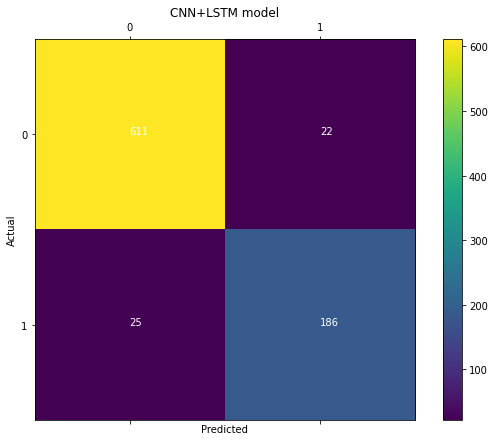

val_loss: 0.10842777788639069
test_loss: 0.18563546240329742
test_acc: 0.9443128108978271
precision: 0.8942307692307693
recall: 0.8815165876777251
specificity 0.9652448657187994
sensitivity :  0.8815165876777251
far 0.03475513428120063
frr 0.11848341232227488


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 183, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 63, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 21, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.5825123831711266)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(108)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(148, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(10, activation = 'relu')(dense_1)
# dense_3 = tf.keras.layers.Dense(139, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.00014136930875531704), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0461300729767683, momentum=0.4411297369087802), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])

# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)